Import Nessessary Modules and Constants

In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
EPOCH = 50
IMAGE_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 32 
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# ⭐ DATA PREPROCESSING

## Import the dataset

In [4]:
# import the dataset from local storage
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "../../../data/CNN/formatted/224_formatted", 
    seed = 123,
    shuffle=True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)

Found 912 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

# Count images in each class
class_counts = {class_name: len(os.listdir(os.path.join("../../../data/CNN/formatted/224_formatted", class_name))) for class_name in class_names}
print("Image counts per class:", class_counts)

['sctld_coral', 'unaffacted_coral']
Image counts per class: {'sctld_coral': 463, 'unaffacted_coral': 449}


In [6]:
# this is going to be the shape of the inputs. 32 images per batch, 224x224 images, and 3 channels since the images are in RGB.
for image_batch, labels_batch in dataset.take(1):
    print(f"random batch shape: {image_batch.shape}")

random batch shape: (32, 224, 224, 3)


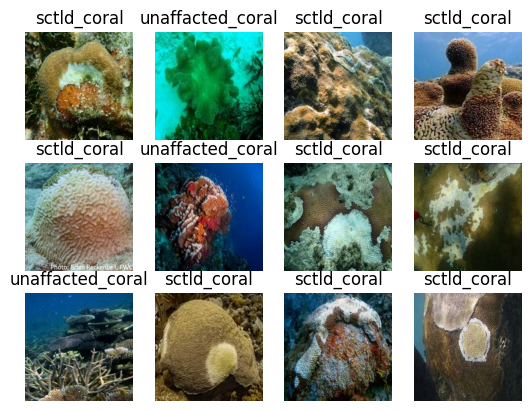

In [7]:
# snippet of what the dataste looks like for the first batch with image labels
for image_batch, label_batch in dataset.take(1):
    for i in range(12): 
        ax = plt.subplot(3,4,i+1) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
      

## Split the dataset into 80-10-10 partitions for 80% training, 10% validation and testing data

**Function get_dataset_partitions_tf: Splits a TensorFlow dataset into training, validation, and test sets based on specified proportions.**

Parameters:
- ds (tf.data.Dataset): The input dataset to be split.
- train_split (float): The proportion of data allocated to the training set (default is 0.8).
- val_split (float): The proportion of data allocated to the validation set (default is 0.1).
- test_split (float): The proportion of data allocated to the test set (default is 0.1).
- shuffle (bool): Whether to shuffle the dataset before splitting (default is True).
- shuffle_size (int): The buffer size for shuffling the dataset (default is 1000).

Returns:
- train_ds (tf.data.Dataset): The training dataset.
- val_ds (tf.data.Dataset): The validation dataset.
- test_ds (tf.data.Dataset): The test dataset.


In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):  
    assert (train_split + test_split + val_split == 1), "Splits must sum to 1."

    ds_size = len(ds)  # Get total number of samples in the dataset
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset for randomness so the model doesn't learn the patters of the order of the images
    
    train_size = int(train_split * ds_size)  # Calculate training set size
    val_size = int(val_split * ds_size)  # Calculate validation set size

    train_ds = ds.take(train_size)  # Take first `train_size` samples for training
    val_ds = ds.skip(train_size).take(val_size)  # Skip training samples and take `val_size` for validation
    test_ds = ds.skip(train_size).skip(val_size)  # Remaining samples are assigned to the test set

    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
print(f"Number of batches in train dataset: {len(train_ds)}")
print(f"Number of batches in test dataset: {len(test_ds)}")
print(f"Number of batches in validation dataset {len(val_ds)}")

Number of batches in train dataset: 23
Number of batches in test dataset: 4
Number of batches in validation dataset 2


## Data Augumentaton and Training Malipulation
This section defines pre-written layers for resizing and rescaling input images, as well as applying data augmentation to improve model generalization.

### Optimize dataset performance by caching, shuffling, and prefetching

- **Caching**: Stores the dataset in memory to speed up access during training.
- **Shuffling**: Randomizes the order of data to prevent the model from learning unintended patterns.
- **Prefetching**: Loads data in advance to improve training efficiency by reducing I/O latency.


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
# Pre-written layder to resize the input images as 224x224 if end user inputs an images that's not 224x224. Also added rescaling to normalize the pixe
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

#### Resize and Rescale Layer
The following layer ensures that any input image is resized to 224x224 pixels and its pixel values are normalized by rescaling them to a range of 0 to 1 (by dividing by 255). 

#### Data Augmentation Layer
The data_augmentation layer is designed to introduce random transformations on the input images during training to prevent overfitting and improve model robustness

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.1)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

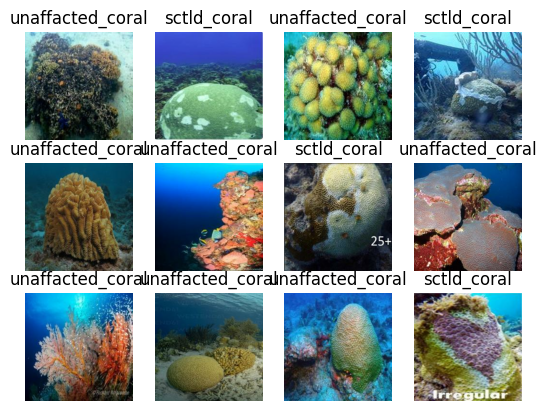

In [14]:
# Visualize the data augumentation
for image_batch, label_batch in dataset.take(1):
    for i in range(12): 
        ax = plt.subplot(3,4,i+1) 
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

# ⭐ MODEL BUILDING

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale, # apply resize and rescale
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=INPUT_SHAPE)


In [18]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 9216)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │         589,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 2)                     │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,266 (2.61 MB)

 Trainable params: 683,266 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

# ⭐ MODEL TRAINING 

Optimizer: The Adam optimizer for adaptive learning rate

Loss Function: The model uses SparseCategoricalCrossentropy for multi-class classification tasks, where the target labels are integers 

Metrics: We are tracking validation accuracy during training to evaluate model performance.

In [19]:
from tensorflow.keras.metrics import *
metrics = ['accuracy']
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics 
)

from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,              # Stop training if no improvement after 5 epochs
    mode='max',             # We want the highest validation accuracy
    restore_best_weights=True  # Restore the model weights from the epoch with the highest validation accuracy
)

In [20]:
for image_batch, labels_batch in dataset.take(1): 
    print(image_batch.shape)
    print(labels_batch)

(32, 224, 224, 3)
tf.Tensor([1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1], shape=(32,), dtype=int32)


In [21]:
# Using ModelCheckpoint to save the best weights with the epoch with the lowest vaidation loss
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath='model_ver2.weights.h5', 
    save_weights_only=True,          
    monitor='val_loss',            
    mode='min',                       
    save_best_only=True               
)

In [22]:
history= model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE, 
    verbose = 1, 
    validation_data = val_ds,
   callbacks=[checkpoint_callback]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.5043 - loss: 0.7203 - val_accuracy: 0.5781 - val_loss: 0.6505
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.6197 - loss: 0.6254 - val_accuracy: 0.7656 - val_loss: 0.5318
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.7032 - loss: 0.5739 - val_accuracy: 0.6719 - val_loss: 0.6749
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.6732 - loss: 0.6071 - val_accuracy: 0.7344 - val_loss: 0.4924
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.7464 - loss: 0.5043 - val_accuracy: 0.7344 - val_loss: 0.5400
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.7463 - loss: 0.5148 - val_accuracy: 0.7656 - val_loss: 0.4833
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.7528 - loss: 0.5202 - val_accuracy: 0.7344 - val_loss: 0.5051
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.7970 - loss: 0.4525 - val_accuracy: 0.

In [23]:
history.history.keys()
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

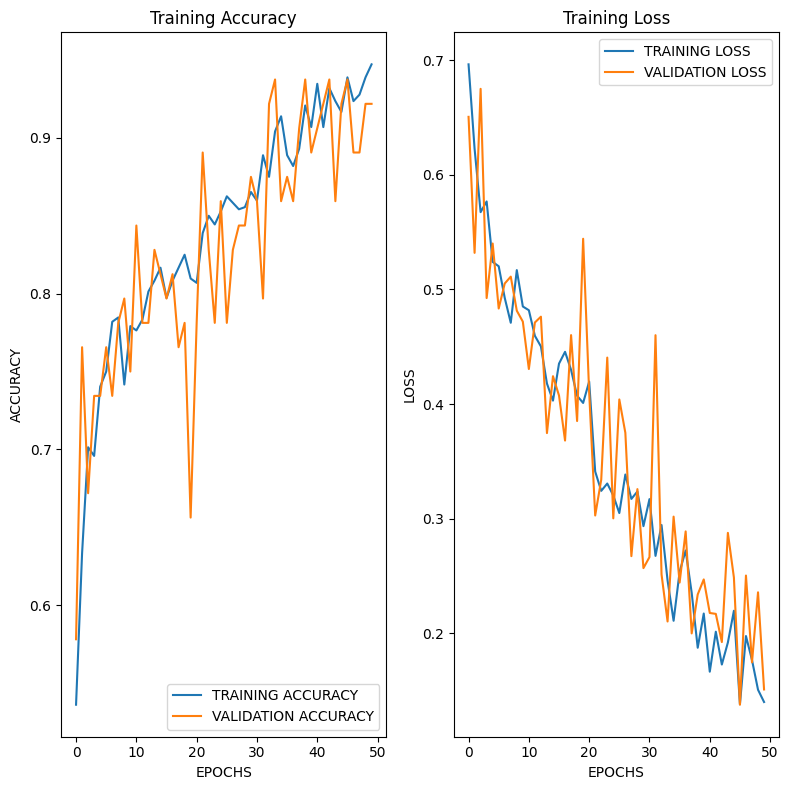

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize = (8, 8))


plt.subplot(1, 2, 1)
plt.plot(range(50), accuracy, label ='TRAINING ACCURACY')
plt.plot(range(50), val_accuracy, label = 'VALIDATION ACCURACY')
plt.title("Training Accuracy")
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label ='TRAINING LOSS')
plt.plot(range(50), val_loss, label = 'VALIDATION LOSS')
plt.title("Training Loss")
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.legend()

plt.tight_layout() 
plt.show()


In [25]:
import numpy as np

y_true = []
y_pred = []

for batch in test_ds:  
    x_batch, y_batch = batch 
    y_true.extend(y_batch.numpy())  
    predictions = model.predict(x_batch)  
    y_pred.extend(predictions)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

y_pred_binary = (y_pred > 0.5).astype(int) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


In [26]:
import numpy as np

y_pred_binary_1d = np.argmax(y_pred_binary, axis=1)
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_binary_1d shape: {y_pred_binary_1d.shape}")



y_true shape: (128,)
y_pred_binary_1d shape: (128,)


In [43]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

f1 = f1_score(y_true, y_pred_binary_1d)
recall = recall_score(y_true, y_pred_binary_1d)
precision = precision_score(y_true, y_pred_binary_1d)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(classification_report(y_true, y_pred_binary_1d))


F1 Score: 0.9538461538461539
Recall: 0.9393939393939394
Precision: 0.96875
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        62
           1       0.97      0.94      0.95        66

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128



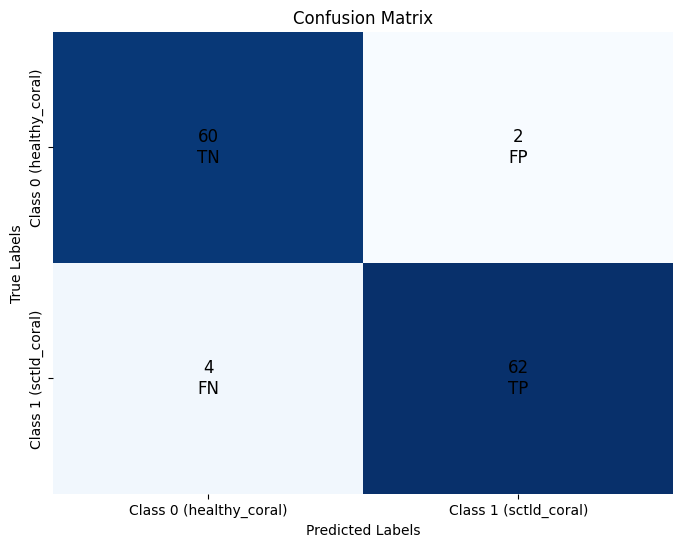

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_binary_1d)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", cbar=False, 
                 xticklabels=["Class 0 (healthy_coral)", "Class 1 (sctld_coral)"], 
                 yticklabels=["Class 0 (healthy_coral)", "Class 1 (sctld_coral)"])
for i in range(2):
    for j in range(2):
        label = ""
        if i == 0 and j == 0:
            label = f"{cm[i, j]}\nTN"
        elif i == 0 and j == 1:
            label = f"{cm[i, j]}\nFP"
        elif i == 1 and j == 0:
            label = f"{cm[i, j]}\nFN"
        elif i == 1 and j == 1:
            label = f"{cm[i, j]}\nTP"
        ax.text(j + 0.5, i + 0.5, label, ha="center", va="center", fontsize=12, color="black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


⭐MODEL EVALUATION AND MERTICS

In [45]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9396 - loss: 0.1052
Test Loss: 0.09303069859743118
Test Accuracy: 0.953125


In [35]:
import numpy as np

y_true = []
y_pred = []

for batch in test_ds:  
    x_batch, y_batch = batch 
    y_true.extend(y_batch.numpy())  
    predictions = model.predict(x_batch)  
    y_pred.extend(predictions)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

y_pred_binary = (y_pred > 0.5).astype(int) 



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


In [36]:
import numpy as np

y_pred_binary_1d = np.argmax(y_pred_binary, axis=1)
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_binary_1d shape: {y_pred_binary_1d.shape}")


y_true shape: (128,)
y_pred_binary_1d shape: (128,)


In [48]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report

f1 = f1_score(y_true, y_pred_binary_1d)
recall = recall_score(y_true, y_pred_binary_1d)
precision = precision_score(y_true, y_pred_binary_1d)
auc = roc_auc_score(y_true, y_pred_binary_1d)
accuracy= accuracy_score(y_true, y_pred_binary_1d)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f'AUC: {auc}')
print(f'ACCURACY: {accuracy}')

print(classification_report(y_true, y_pred_binary_1d))


F1 Score: 0.9538461538461539
Recall: 0.9393939393939394
Precision: 0.96875
AUC: 0.9535679374389052
ACCURACY: 0.953125
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        62
           1       0.97      0.94      0.95        66

    accuracy                           0.95       128
   macro avg       0.95      0.95      0.95       128
weighted avg       0.95      0.95      0.95       128



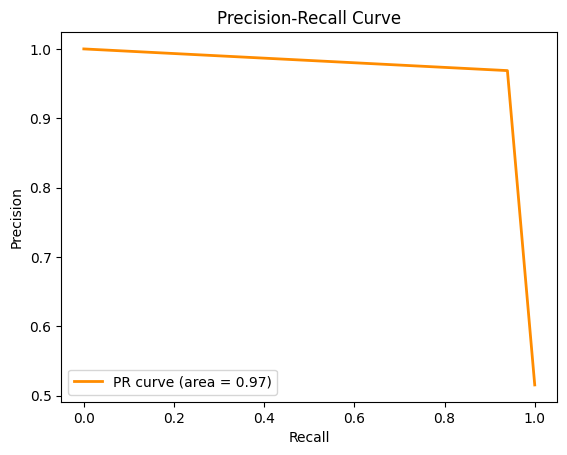

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true, y_pred_binary_1d)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()





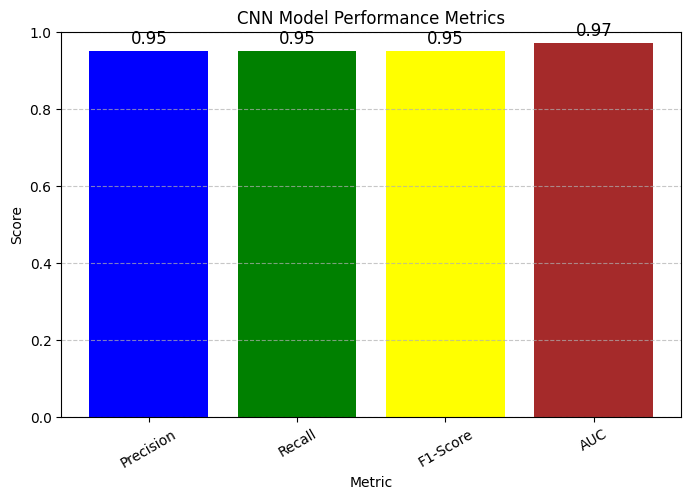

In [41]:
import matplotlib.pyplot as plt

# Example results dictionary (replace with your actual metrics)
results = {
    'Precision': 0.95, 
    'Recall': 0.95, 
    'F1-Score': 0.95,
    'AUC' : 0.97
}

plt.figure(figsize=(8, 5))
bars = plt.bar(results.keys(), results.values(), color=['blue', 'green', 'yellow','brown' ])
plt.xticks(rotation=30)
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("CNN Model Performance Metrics")
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(results.values()):
    plt.text(i, v + 0.02, str(round(v, 3)), ha='center', fontsize=12)


plt.show()


In [52]:
def predict(model, img): 
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis = 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 

Batch size: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

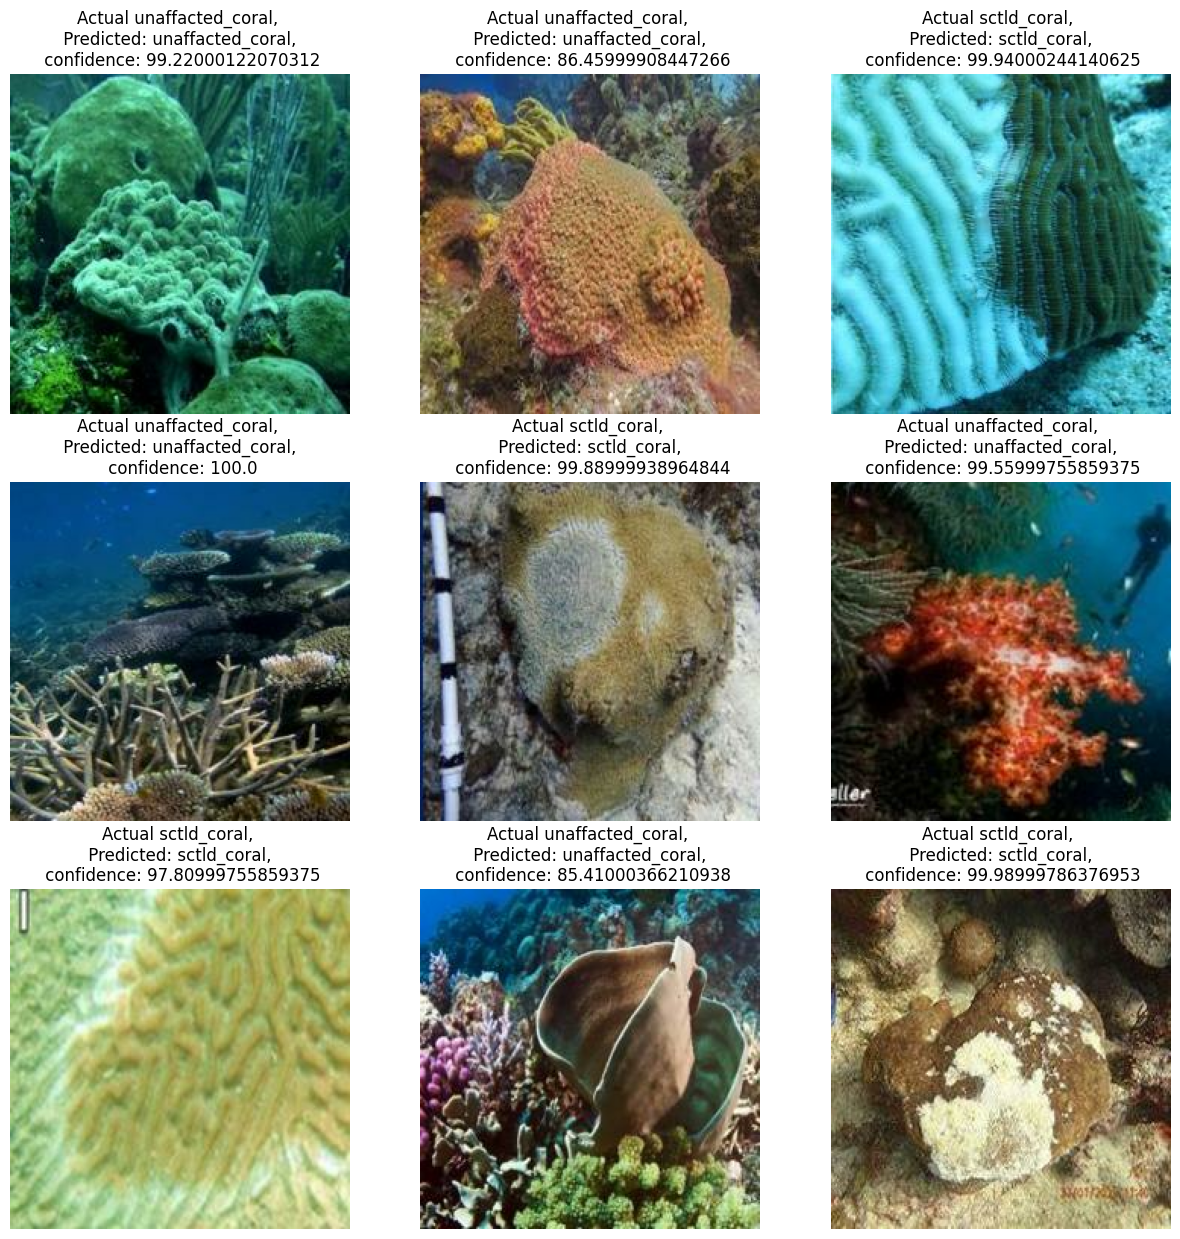

In [47]:
def predict(model, img): 
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, axis = 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]
    print(f"Batch size: {batch_size}")
   # plt.imshow(images.numpy().astype("uint8"))
    for i in range(32):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual {actual_class}, \n Predicted: {predicted_class}, \n confidence: {confidence}")
        plt.axis("off")
        

In [74]:
model.export(f"../models/new_models/1_ver/{model_version}")

INFO:tensorflow:Assets written to: ../models/new_models/1_ver/1\assets


INFO:tensorflow:Assets written to: ../models/new_models/1_ver/1\assets


Saved artifact at '../models/new_models/1_ver/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2264266960784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264266958672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291602320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291591952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291590800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291594640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291602896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291604432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291604240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291605008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264291603088: TensorS

In [3]:
import pandas as pd

# history_df = pd.DataFrame(history.history)
# history_df.to_csv('../../../models/history/1_model_training_history.csv', index=False)

In [31]:
from tensorflow import keras

model = keras.models.load_model("../../../models/new_models/1.keras")

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 514,184 (1.96 MB)

 Trainable params: 171,394 (669.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 342,790 (1.31 MB)

In [32]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9773 - loss: 0.0583 
Test Loss: 0.03972256928682327
Test Accuracy: 0.9910714030265808
